<a href="https://colab.research.google.com/github/stevenandreu/Guam-Data/blob/main/SurfPerch_Guam_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SurfPerch Tutorial with Calling in Our Corals** 🐠🐦

This notebook was adapted from the original NeurIPS workshop tutorial 'CCAI Agile Modeling for Bioacoustic Monitoring Tutorial', authored with equal contribution by:
*   Jenny Hamer, Google DeepMind
*   Rob Laber, Google Cloud
*   Tom Denton, Google Research

The adaptation presented here was authored by:
* Ben Williams, UCL (Google DeepMind Student Researcher)

# Table of Contents
*   [Introduction](#introduction)
  - [Background](#background)
  - [Calling in Our Corals](#cioc)
  - [SurfPerch](#SurfPerch)
  - [Glossary](#glossary)
  - [Agile Modeling for Bioacoustics](#agile_modeling)
  - [Software Requirements](#software-requirements)
  - [Adapting to New Use Cases](#adapting)
*   [Set Up](#set-up)
*   [Methodology](#methodology)
  - [Embed the Search Dataset](#embed_data)
  - [Audio Similarity Search](#similarity-search)
  - [Active Learning](#active-learning)
*   [Results](#results)

<a name=introduction></a>
# Introduction

> (8 min read)



<a name=background></a>
## Background

Passive acoustic monitoring (PAM) can be used to collect valuable information on the state of marine habitats. However, this data can easily range from dozens to thousands of hours in size, becoming too large for marine scientists to manually analyse. Machine learning offers a powerful solution to this challenge.

The goals of this notebook are:
1. Provide marine scientists with a workflow that enables them to rapidly anaylse PAM data using machine learning.
2. Guide users through how to build a highly accurate machine learning detector known as a 'classifier' for any given sound of interest in their dataset, starting from a single example.
3. Demonstrate how this can be run entirely from this notebook using data uploaded to Google Drive.

We demonstrate this using data gathered for the Calling in Our Corals project.


<a name=cioc></a>
## Calling in Our Corals

Coral reef habitats have rich and diverse soundscapes. However, a key challenge bioacousticians working on these habitats must overcome is identifying which sounds are of interest. For any given dataset, the source of most of sounds are typically unknown and undocumented making it challenging for marine bioacousticians to know where to begin.

[Calling in Our Corals](https://artsandculture.google.com/experiment/calling-in-our-corals/zgFx1tMqeIZyTw?hl=en) (CIOC) is a collaboration started in 2023 between Google Arts and Culture and marine biologists hoping to overcome this challenge. The project is centred around a platform used to crowd source annotations for marine acoustic data. Over 24'000 unique users logged on to the platform and listened to a combined 400 hours of audio recorded from marine habitats in 10 different countries, annotating any periods they identified as containing sounds of interest. By taking the audio clips with the highest number of annotations for each dataset a diverse set of biological sounds were revealed from each.

Here, we use some of these sounds from three datasets as an entry point into our machine learning pipeline. The results shared at the end only represents a preliminary analysis using a subset of the data as scientists continue to work on the outputs. However, we find this reveals interesting patterns between the soundscape and state of the habitats.

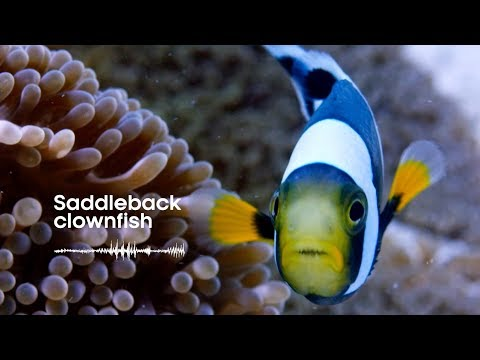

In [ ]:
#@title Learn more about coral reef sounds here
from IPython.display import YouTubeVideo

# YouTube video ID
video_id = "POITH02VVrw"

# Display the YouTube video in the notebook
YouTubeVideo(video_id)

<a name=SurfPerch></a>
## SurfPerch

The Perch effort is comprised of a team of Google researchers focused on making bioacoustics more efficient, more effective and easier to do. So far, the core component of the teams worked has focused on terrestrial bioacouastic challenges. For example, development of the [Perch model](https://doi.org/10.1038/s41598-023-49989-z) which offers a powerful 'pretrained' neural network for terrestrial acoustic challenges.

More recently, the team branched into the marine environment with the introduction of SurfPerch, a sister model to Perch which is optimised for coral reef habitats. To develop SurfPerch the team worked with key collaborators to assemble ReefSet, a library of annotated reef sounds. However, ReefSet is still modest in size compared to other bioacoustic fields. The secret to success of SurfPerch actually came from mixing ReefSet with the very same bird datasets used to train Perch, alongside more general audio from the Freesound 50k dataset. More details can be found in the models supporting [research article](https://doi.org/10.48550/arXiv.2404.16436).

SurfPerch should offer a powerful tool for studying the acoustics of coral reefs and other aquatic habitats where fish and similar sounds are the primary target. This tutorial will walk you through how to use this from start to end.




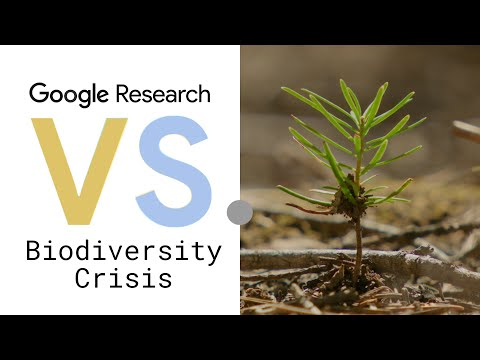

In [ ]:
#@title Learn more about the Perch teams previous work here
# YouTube video ID
video_id = "-d9IRea_P3M"

# Display the YouTube video in the notebook
YouTubeVideo(video_id)

<a name=glossary></a>
## Glossary 📖

We provide a high-level, intuitive description of some of the core components and machine learning concepts utilized this tutorial.

### Agile Modeling

Agile modeling in the context of supervised machine learning can be described as “the process of turning any subjective visual concept into a computer vision model through real-time user-in-the-loop interactions” ([Stretcu et al. 2023](https://arxiv.org/abs/2302.12948)). In our setting, we go beyond the typical image and computer vision settings to explore the audio domain, where we use this to **rapdily build an accurate classifier from a single labeled audio sample.**



### Transfer Learning

Transfer learning is a technique that relies on the reuse of a pretrained model on a new task (different dataset from which it was trained). This technique assumes that the pre-training of the model produces a useful representation and knowledge that can be extended to the new task/setting. In the context of this tutorial we use SurfPerch, a model pretrained on a large acoustic dataset of coral reef, bird and general audio clips to produce embeddings of a new soundscape dataset (passive recordings).


**Intuition:** in the context of bioacoustics, transfer learning is useful for building a general representation that can translate to new sounds or geographical regions, particularly when labeled data is scarce. Using a pretrained model with transfer learning lowers the machine learning overhead for field experts and practitioners who seek to understand and interpret unlabeled data, such as that from passive acoustic monitoring (PAM).

### Active Learning

Active Learning is a general term for an iterative, supervised ML technique that efficiently makes use of labeled data to “learn the labels” or classify unlabeled data. This learning setting is particularly helpful in scenarios where unlabeled data is abundant and producing labels for that data is costly, requires expert knowledge, lots of manual work, etc.

### Embeddings

At their core, neural networks function by learning new representations of data that help make the underlying patterns in the dataset more obvious.  These representations are called **embeddings**.  Concretely, an embedding is a point (or vector) in a high dimensional space.  Data points with embeddings that are close to each other are likely to share salient traits.

<a name=agile_modeling></a>
## Agile Modeling for Bioacoustics

The core problem this tutorial addresses lies in biodiversity monitoring using large-scale, unlabeled audio data, as collected by inexpensive passive acoustic monitoring (PAM) devices. We present an **integrated workflow** for analyzing large unlabeled bioacoustic datasets, adapting new [agile modeling techniques](https://arxiv.org/abs/2302.12948) to the audio domain. The tools we provide enable users to adapt a classifier for a novel class (species, specific call type, etc...) with minimal overhead.

Our goal is to **allow experts to create classifiers for new sounds in less than an hour.**

The overall flow has three main parts:
* First, we use a high-quality *embedding model* to produce embeddings of a large unlabeled dataset, such as a conservation organization might collect. This produces a large table of embeddings, which can be easily joined back to the original audio. (For large datasets, this step may take a substantial amount of time, but only needs to be done once: All later steps make use of these precomputed embeddings.)

* Next, we use audio similarity search to sift through the unlabeled dataset embeddings for sounds of interest. The user provides a query—an example of a sound category they are searching for, like a juvenile call for a particular species—which is also embedded, and we present the user with the most relevant dataset elements according to their embeddings' similarity to the query embedding. The user marks the retrieved dataset elements as relevant or irrelevant, which provides training data for the next step.
   
  - The similarity search over embeddings allows us to find similar audio examples, even when there is some variation, vocalizations are quiet, or there are overlapping sounds.
  
  - In the example below, we are able to find relevant examples of hairy woodpecker drumming sounds (blue) even in the presence of competing sounds (brown).  The [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) on the left is a known vocalization of a hairy woodpecker.  The similarity search algorithm allows us to detect instances of this vocalizations in an audio context that may have
  other background noise (the three spectrograms on the right, with background noise indicated in brown):
  > ![search](https://docs.google.com/drawings/d/e/2PACX-1vSIwCEkHNEjtyh3PLhTa-4hTTaBoMnWGVXobr91rKeD7m52a4ES9K0JZ_tqltasUWctgLHnf2PrvtKU/pub?w=371&h=253)
  


* The final step is to use the training data obtained in the previous step as part of an active learning loop to train a classifier for the user's search query. During each iteration of the loop, we fit a simple classifier onto the training data. We use the trained classifier along with margin sampling to efficiently surface 'hard' examples that are then rated by the user as relevant or irrelevant to their query. Finally, the newly-rated data is added to the training data for the next iteration of the active learning loop. The fact that embeddings are only computed once on the unlabeled dataset means that each iteration of the loop is very fast to carry out.

The core of this process is a high-quality model for bioacoustic data. [We have shown](https://arxiv.org/pdf/2307.06292.pdf) that the embeddings from our [global bird classification model](https://tfhub.dev/google/bird-vocalization-classifier/4) transfer efficiently to novel bioacoustic problems - including bird call-types, bats, and marine mammals - outperforming general audio foundation models. Now with SurfPerch, we present a new model that outperforms all others in the coral reef domain, and likely similar aquatic habitats. Additionally, because we work with precomputed embeddings, the classifiers are very quick to train and to apply to the unlabeled dataset.

<a name=software-requirements></a>
## Software Requirements

The majority of the code is contained in a publicly accessible repository hosted on github: https://github.com/google-research/perch.

**Note:** This repository was formerly named 'chirp', so any references to 'chirp' in the code below are references to code in this Perch repository.

The Perch codebase contains a variety of processing and machine learning tooling for working with audio datasets, with a focus on avian acoustics which we have also adapted for reef acoustics.  This tutorial demonstrates only some of the functionality provided by the Perch codebase.  **Therefore, there are section of this tutorial where we ask the reader to configure default values that are targeted to this specific use case and tutorial.  In order to keep this tutorial focused, we will selectively discuss only the most relevant parameters, and we refer the reader to the github repository for more background and context.**

To use this tutorial, we rely on the off-the-shelf Google Colab runtime (Python 3 Google Compute Engine backend). This has the majority of the required packages already installed and meet the version requirements. If you are using this, then **no action is required**. Packages include:
* python, version 3.10+
* NumPy, version 1.2+
* Tensorflow, version 2+
* [tqdm](https://tqdm.github.io/), version 4.6+

You should be able to use any of the three free provided backends available as of Fall 2023 (CPU, T4 GPU, or TPU).

<a name=adapting></a>
## Adapting for new use cases

We hope this notebook will provide a foundation for marine biologists to adapt this to their own data and uses cases. Through uploading new data to Google Drive and mimicking the folder structure presented in the `SurfPerch Demo with Calling in Our Corals Data` folder we share, this notebook can be applied to novel data with minimal changes. Advanced users may wish to adapt the notebook further, or clone the Perch repository and run this locally on their own hardware.

<a name=set-up></a>
# Set Up

<a name=Introduction></a>
## Install the `perch` codebase from GitHub
This will take several minutes.

**Important:** Click restart the Colab runtime after install completes and proceed.

In [1]:
!pip install git+https://github.com/google-research/perch.git@373253f5887e2964a51f348e107889dadfdcece0

  Cloning https://github.com/google-research/perch.git (to revision 373253f5887e2964a51f348e107889dadfdcece0) to /tmp/pip-req-build-ggackcum
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/perch.git /tmp/pip-req-build-ggackcum
  Running command git rev-parse -q --verify 'sha^373253f5887e2964a51f348e107889dadfdcece0'
  Running command git fetch -q https://github.com/google-research/perch.git 373253f5887e2964a51f348e107889dadfdcece0
  Running command git checkout -q 373253f5887e2964a51f348e107889dadfdcece0
  Resolved https://github.com/google-research/perch.git to commit 373253f5887e2964a51f348e107889dadfdcece0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Over time dependancy conflicts may arise on Colab. If this install cell or the import cell below do not succesfully execute after the pip install and restart, check:
- The [SurfPerch Github](https://github.com/BenUCL/surfperch/tree/surfperch) for an updated version of this notebook.
- The original [NeurIPS Workshop Tutorial](https://colab.research.google.com/drive/1gPBu2fyw6aoT-zxXFk15I2GObfMRNHUq?usp=sharing) for updates to the install or imports. If you encounter an issue at the install and import this other notebook should work. You may then encounter issues at cells further down, if this is the case replace the problematic cells in this SurfPerch notebook with the corresponding cells from the NeurIPS CCAI notebook.
- The [Perch GitHub repository](https://github.com/google-research/perch) for open or closed issues on installs and imports.

Alternatively, the Perch repository will contain maintened versions of the notebooks (.ipynb files) needed to run this workflow. You can download and install Perch to your local machine, instead of Colab, by following instructions in the ReadMe on the Perch GitHub.

## Load the required imports


Beyond the `perch` package pip-installed in the cell above, all other required libraries are already either covered within that installation or already installed in the default Python 3 Google Compute Engine backend/runtime.

We note again that any `chirp` modules are provided by the Perch code.

## Accessing the datasets

We will make use of three datasets. The original data for each totals in the dozens to thousands of hours. For simplicity, here we will work with 15-25 hours from each. Some of the most commonly identified sounds by CIOC have been taken from each and will be used. Many of these sounds are of an unknown orign, most likely reef fish. Each dataset can be divided into two or more ecological categories. We will explore whether acoustic data can be used to identify differences between these ecological categories.

### Australia
The Australian dataset was gathered from 8 sites around [Lizard Island Research Station](https://maps.app.goo.gl/Kyry7XcgEuxt7jNUA) on the Great Barrier Reef. Here, sites can be divided into high and low fish diversity sites. **For an easy first pass through this tutorial, try starting with the Ambon Damselfish sound from this dataset** when prompted later. We thank Dr Laura Laura Richardson, University of Bangor, and other co-authors of [Wiliams et al (2024)](https://doi.org/10.1101/2024.02.02.578582) for providing this dataset.

### Indonesia
The Indonesian dataset was gathered from 18 sites around [HOPE Reef](https://maps.app.goo.gl/fqfyecnXbVgjHi7B9) in Indonesia, pictured below. Hope is the flagship site of the worlds largest coral reef restoration program, you can read more about this intitiative at [buildingcoral.com](https://www.buildingcoral.com/). We will use recordings taken from healthy, degraded and restored sites.

<img src="https://raw.githubusercontent.com/BenUCL/surfperch/surfperch/manuscript-additions/colab_pics/hope_reef.jpg" width="50%">


### Philippines
This dataset was gathered from 10 sites within the Philippines. These sites were split evenly into protected and unprotected categories. This dataset is detailed further on the Calling in Our Corals platform. We thank Mary Shodipo, University of Miami, who collected this data from the Visayas region of the central Philippines.

## Data Hosting in Google Drive

First, we will connect your Google Drive to this Colab instance. Grant all permissions to the windows which are opened.



In [2]:
# The necessary pipeline to connect this Colab environment with the Google Drive
# folder where we host the data used in this tutorial.
import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# Create the folder to store the sample data
drive_sample_data_folder = '/content/drive/MyDrive/SurfPerch Guam Data/'
if not os.path.exists(drive_sample_data_folder):
  os.mkdir(drive_sample_data_folder)

# This is the location that this tutorial will use to save data.
drive_output_directory = '/content/drive/MyDrive/SurfPerch Guam Output/'
if not os.path.exists(drive_output_directory):
  os.mkdir(drive_output_directory)

Mounted at /content/drive


## Copy sample data to your Google Drive

This cell will copy the public sample data to your Google Drive. This will take several minutes. **You will need 6.5GB of free space in your Google Drive**.

**If you do not have this space**, you can instead create a temporary copy of this data for the current Colab instance. Note, it will be lost once the instance is disconnected:
1. Change the `drive_sample_data_folder` folder path above by removing the
 `/drive/MyDrive` component.
2. Change the two referecnes to  the folder path below to also remove the
 `/drive/MyDrive` component.

❗Note, you will only ever need to run the below cell once❗

Once the cell has been run, this data will be accessible from your Drive using new Colab instances as long as you don't delete or move it within your Drive, meaning you do not need to rerun this cell if starting over.

In [ ]:
# Copy the sample data from GCS to Google Drive. If you are accidentally running this again, it is safe to interupt this cell and move on.
print('Copying data to Google Drive...')
!gsutil -m rsync -r gs://chirp-public-bucket/surfperch/ "/content/drive/MyDrive/SurfPerch Demo with Calling in Our Corals Data/" # Folder path reference 1

# Check the folders got copied. We need the SurfPerch-model, Australia, Indonesia and Philippines folders.
!echo "Folders successfully copied:" && ls -l "/content/drive/MyDrive/SurfPerch Demo with Calling in Our Corals Data/" | grep "^d" # Folder path reference 2

<a name="methodology"></a>
# Methodology 💻

## Overview

Our method performs a **vector search**: given a **labeled** vocalization which we'll refer to as a **query** (an audio clip with a known species vocalizing), an unlabeled audio dataset which we'll refer to as our **search corpus** (in our case, a soundscape dataset from one the three coral reef datasets), slice up the search corpus into a collection of clips and search over that corpus to find "matches" with the query.

To do this, we'll follow theses high level steps:

**Step 2:** Set up by importing the relevant modules, choosing a dataset and testing the model. We recommend the Australian dataset and the Ambon Damselfish for an easy first run through.

**Step 2:** Use the "off the shelf" SurfPerch model to generate high quality embeddings for the unlabeled **search corpus** (ie the Indonesian dataset).

**Step 3:** Obtain a small number of **query** samples as target sounds, which are labeled samples of unknown fish sounds found by CIOC.

**Step 4:** Select a query sample and generate the embedding(s) from this.

**Step 5:** Search within the set of embeddings generated from the search corpus (the raw audio data) for points that are "nearby" the embedding generated from the query sample. This yields a set of audio snippets from the audio data that should sound similar to the query.

**Step 6:** Manually audit the results of step 4. This involves listening to a small number of samples and manually labeling them as a match to our target query or not.

--------------------
**Note:** Aim to repeat steps 5 and 6 until we have 20-30 samples for our target sound. We are "bootstrapping" a training set for a simple linear model.

--------------------
**Step 6:** Train a simple linear model based on the bootstrapped samples that we just generated.

At this point, we have what should be a high quality classifier that can detect a given target sound in its broader dataset. If our model is not performing as well as we'd like, we can continue to generate more training data by repeating the above process using outputs from our linear model to laebl more data, or repeating the original steps 5 and 6 above.



This section is broken down into the following parts:
*    [Setup and Configuration](#pipeline-config) (Step 1)
*    [Generate Embeddings](#embed_data) (Steps 2, 3, and 4)
*    [Audio Similarity Search](#similarity-search) (Steps 5 and 6)
*    [Train a Linear Classifier](#active-learning) (Step 7)



<a name="pipeline-config"></a>
## Setup and Configuration

In this section, we set the configuration parameters we'll be using to process and embed the audio data, along with input and output paths for reading in the data, pre-trained model, and writing the results we produce to file.

In [3]:
# Import various dependencies, including the relevant modules from the Perch
# repository. Note that "chirp" is the old name that the Perch team used, so any
# chirp modules imported here were installed as part of the Perch repository in
# one of the previous cells.

import collections
from collections import Counter
from etils import epath
from IPython.display import HTML
import ipywidgets as widgets
from IPython.display import display as ipy_display, HTML
import matplotlib.pyplot as plt
from ml_collections import config_dict
import numpy as np
import pandas as pd
from scipy.io import wavfile
import shutil
import tensorflow as tf
import tqdm

from chirp.inference import colab_utils
colab_utils.initialize(use_tf_gpu=True, disable_warnings=True)

from chirp import audio_utils
from chirp import config_utils
from chirp import path_utils
from chirp.inference import embed_lib
from chirp.inference import models
from chirp.inference import tf_examples
from chirp.models import metrics
from chirp.inference.search import bootstrap
from chirp.inference.search import search
from chirp.inference.search import display
from chirp.inference.classify import classify
from chirp.inference.classify import data_lib

# If connected to a Colab GPU runtime we should see a GPU listed
tf.config.list_physical_devices()

2024-11-04 17:44:07.688180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 17:44:07.723072: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 17:44:07.733466: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 17:44:07.765396: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-04 17:44:09.710615: W tensorflow/comp

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Set the configuration to use throughout the tutorial **[do not change]**

**To the reader: unless you are adapting this pipeline to your own model or dataset, you can skip the details in this section.**

As mentioned above, the Perch codebase provides a general framework for agile modeling, which naturally involves many different configuration options.  We highlight some of the relevant paramers below, and refer the reader to the Perch
codebase for more detail.

For this tutorial using the provided pre-trained model and datasets, the required values for the following parameters are fixed and should not be changed.

**Note** that we will also save the configuration file to support reproducibility (e.g. in the event we wish to work with the embeddings at a later point).

#### Relevant Parameters
* `window_size_s`: The size in seconds of each "chunk" of audio.  Each chunk of audio will be treated like
 a single data point. Note that the model architecture depends on this value, so once selected it cannot be changed.

* `hop_size_s`: The hop size (aka model [*stride*](https://medium.com/machine-learning-algorithms/what-is-stride-in-convolutional-neural-network-e3b4ae9baedb)) is the offset in seconds between successive chunks of audio. When hop_size is equal to window size, the chunks of audio will not overlap at all. Choosing a smaller hop size (a common choice is half of the window_size) may be useful for capturing interesting data points that
correspond to audio on the boundary between two windows. However, a smaller
hop size may also lead to a larger embedding dataset because each instant of
audio is now pesent in multiple windows. As a consequence, you might need to
"de-dupe" your matches since multiple embedded data points may correspond to the same snippet of raw audio.

* `sample_rate`: We use a uniform sample rate of 32 kHz. All audio used for training the base model and generating embeddings is (re)sampled at 32 kHz. This parameter, together with the `window_size_s` of 5 means that each snippet of audio gets represented as a vector of length 5s * 32,000Hz = 160,000.  The value 160,000 must be compatible with your model architecture.

In [4]:
# Model specific parameters: PLEASE DO NOT CHANGE THE CODE IN THIS CELL.
config = config_dict.ConfigDict()
embed_fn_config = config_dict.ConfigDict()
embed_fn_config.model_key = 'taxonomy_model_tf'
model_config = config_dict.ConfigDict()

# The size of each "chunk" of audio.
model_config.window_size_s = 5.0

# The hop size
model_config.hop_size_s = 5.0

# All audio in this tutorial is resampled to 32 kHz.
model_config.sample_rate = 32000

# The location of the pre-trained model.
model_config.model_path = drive_sample_data_folder + 'SurfPerch-model/'

# Only write embeddings to reduce size. The Perch codebase supports serializing
# a variety of metadata along with the embeddings, but for the purposes of this
# tutorial we will not need to make use of those features.
embed_fn_config.write_embeddings = True
embed_fn_config.write_logits = False
embed_fn_config.write_separated_audio = False
embed_fn_config.write_raw_audio = False

config.embed_fn_config = embed_fn_config
embed_fn_config.model_config = model_config

# These two settings can be used to break large inputs up into smaller chunks;
# this is especially helpful for dealing with long files or very large datasets.
# Given free colab has limited resources, you may want to reduce shard_len_s to
# 10 to prevent system RAM from becoming overloaded.
config.shard_len_s = 60 #
config.num_shards_per_file = -1

# Number of parent directories to include in the filename. This allows us to
# process raw audio that lives in multiple directories.
config.embed_fn_config.file_id_depth = 1

# If your dataset is large its useful to split the TFRecords across multiple
# shards so I/O operations can be parallized.
config.tf_record_shards = 10

### Specify the data (inputs) and results (outputs) directories

You do not need to change these values for this tutorial - the values already specified should map to the provided data hosted in Google Drive, and will map to the folder in your local Drive for which you added the shorcut.

To execute this pipeline, we need paths to:
- `unlabeled_audio_pattern`: the file within Drive where the unlabeled audio dataset is stored.
- `embedding_output_dir`: the directory where the embedded audio will be written.
- `labeled_data_path`: the directory where the labeled samples will be placed post-search and active learning loop.

In [ ]:
# @title Hit run on this cell and choose a dataset
# Custom CSS to increase label width
style = """
<style>
.widget-label {
    min-width: 100px !important;
}
</style>
"""

# Apply the CSS
ipy_display(HTML(style))

# Define the dropdown
dropdown = widgets.Dropdown(
    options=['Indonesia', 'Australia','Philippines'],
    value='Australia',
    description='Current choice:',
    disabled=False,
)

# Define a function that reacts to changes in the dropdown
def on_dataset_change(change):
    dataset_choice = change['new']
    print(f'Changed dataset to: {dataset_choice}. Now work through the cells below for this dataset.')

# Attach the observer to the dropdown
dropdown.observe(on_dataset_change, names='value')

# Display the dropdown
ipy_display(dropdown)



In [5]:

# Specify a glob pattern matching any number of wave files.
# Use [wW][aA][vV] to match .wav or .WAV files
unlabeled_audio_pattern = os.path.join(drive_sample_data_folder, 'Ch1_Guam_Unf Day 2/*.[wW][aA][vV]')

# Specify a directory where the embeddings will be written.
embedding_output_dir = os.path.join(drive_output_directory, 'raw_embeddings/')
if not os.path.exists(embedding_output_dir):
  os.makedirs(embedding_output_dir, exist_ok=True)

config.output_dir = embedding_output_dir
config.source_file_patterns = [unlabeled_audio_pattern]

# Create output directory and write the configuration.
output_dir = epath.Path(config.output_dir)
output_dir.mkdir(exist_ok=True, parents=True)

# Don't forget to run the dropdown cell above!

### Write the configuration to JSON to ensure consistency with later stages of the pipeline

In [6]:
# This dumps a config json file next to the embeddings that allows us to reuse
# the same embeddings and ensure that we have the correct config that was used
# to generate them.
embed_lib.maybe_write_config(config, output_dir)

# Create SourceInfos configuration, used in sharded computation when computing
# embeddings. These source_infos contain metadata about how we're going to
# partition the search corpus.  In particular, we're splitting the Powdermill
# audio into hundreds of 5s chunks, and the source_infos help us keep track of
# which chunk came from which raw audio file.
source_infos = embed_lib.create_source_infos(
    config.source_file_patterns,
    config.num_shards_per_file,
    config.shard_len_s)
print(f'Constructed {len(source_infos)} source infos.')

Constructed 73 source infos.


### Load the pre-trained embedding model

We will apply *transfer learning* by using the pretrained SurfPerch to compute the embeddings we will search over. This pretrained model allows us to leverage a rich learned representation so that we do not need to train a custom model for the specific species we search for.

In [13]:
#@title { vertical-output: true }
# Here we're loading our generic Bird Classifier model.
# The embed_fn object is a wrapper over the model.
embed_fn = embed_lib.EmbedFn(**config.embed_fn_config)
print('\n\nLoading model(s)...')
embed_fn.setup()

print('\n\nTest-run of model...')
z = np.zeros([int(model_config.sample_rate * model_config.window_size_s)])
embed_fn.embedding_model.embed(z)
print('Setup complete!')



Loading model(s)...


I0000 00:00:1730743122.826399    1299 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730743122.826827    1299 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730743122.827061    1299 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730743122.963980    1299 cuda_executor.cc:1015] successful NUMA node read from SysFS ha



Test-run of model...


I0000 00:00:1730743153.387073    1299 service.cc:146] XLA service 0x5ce22ffbdb50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730743153.387121    1299 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-11-04 17:59:14.107532: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1730743154.249778    1299 assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
2024-11-04 17:59:15.451206: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
E0000 00:00:1730743157.482109    1299 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1730743157.622302    1299 gpu_timer.cc:183] Delay kernel timed o

Setup complete!


<a name=embed_data></a>
## Generate Embeddings ⏳

In this section we'll generate the **embeddings** corresponding to both our search corpus (the chosen dataset) as well as our query audio (the target sound chosen shortly).

Recall that the embeddings are new representations of the original data that are generated by the pretrained model. It is important to remember that we are **not** using our pretrained model to classify the new reef dataset.  Rather, we're using the model's **learned features** to map our data into a new representation that is more amenable to simpler classification techniques. The pretrained model was very computationally costly to train. So, the idea is that the heavy lifting of learning salient features has already been done during development of the pretrained model. We can use this pretrained model to extract these features from new marine bioacoustic data, then train a much lighter-weight machine learning model on top of these features. This is the concept of **transfer learning**, ie, re-using the features learned by a model, but in a novel setting.


### Process the search dataset

In [14]:
# To reduce the overhead computational resources required and speed up execution
# time, we use multiple threads to load the audio before embedding. This tends
# to perform faster, but can fail if any audio files are corrupt.

# The source_infos variable contains metadata about how to parition the search
# corpus.  This step creates an audio_iterator which iterates over the 5 second
# chunks of audio.

embed_fn.min_audio_s = 1.0
record_file = (output_dir / 'embeddings.tfrecord').as_posix()
succ, fail = 0, 0

audio_loader = lambda fp, offset: audio_utils.load_audio_window(
    fp, offset, model_config.sample_rate, config.shard_len_s)
audio_iterator = audio_utils.multi_load_audio_window(
    audio_loader=audio_loader,
    filepaths=[s.filepath for s in source_infos],
    offsets=[s.shard_num * s.shard_len_s for s in source_infos],
)

### Embed the search dataset
We are ready to generate the embeddings for the raw audio.  This cell iterates over the `audio_iterator` created in the previous cell and creates a point (vector) in *embedding space* for each 5 second chunk of raw audio.  We write these embeddings to files (which are written into your `emebdding_output_dir` directory in GDrive that we specified above), and then return a `ds` variable that is a handle on the resulting TFRecordDataset object.

Writing the embeddings to file is useful because for large datasets, this embedding step can take minutes or hours, and we don't want to have to repeatedly regenerate the embeddings.

**GPU usage**: This component will benefit greatly from using a GPU, which can be selected from the runtime menu. Free GPU usage is limited, you can reduce your usage by first running the notebook up to here on a GPU. You can then switch to a CPU runtime and start over, allowing you to skip past this cell and use the precomputed embeddings now in your GDrive.

❗If you have already computed the embeddings for this dataset, you do not need to run this cell again❗

In [15]:
#@title { vertical-output: true }
# Embed! This step may take several minutes to run.
with tf_examples.EmbeddingsTFRecordMultiWriter(
    output_dir=output_dir, num_files=config.tf_record_shards) as file_writer:
  for source_info, audio in tqdm.tqdm(
      zip(source_infos, audio_iterator), total=len(source_infos)):
    if audio.shape[0] < embed_fn.min_audio_s * model_config.sample_rate:
      # Ignore short audio.
      continue
    file_id = source_info.file_id(config.embed_fn_config.file_id_depth)
    offset_s = source_info.shard_num * source_info.shard_len_s
    example = embed_fn.audio_to_example(file_id, offset_s, audio)
    if example is None:
      fail += 1
      continue
    file_writer.write(example.SerializeToString())
    succ += 1
  file_writer.flush()
print(f'\n\nSuccessfully processed {succ} source_infos, failed {fail} times.')

fns = [fn for fn in output_dir.glob('embeddings-*')]
ds = tf.data.TFRecordDataset(fns)
parser = tf_examples.get_example_parser()
ds = ds.map(parser)
for ex in ds.as_numpy_iterator():
  print('Recording filename:', ex['filename'])
  print('Shape of the embedding:', ex['embedding'].shape)
  break

# This can take a few moments to get started

  0%|          | 0/73 [00:00<?, ?it/s]W0000 00:00:1730743806.426671    1299 assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
E0000 00:00:1730743814.749162    1299 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1730743814.887129    1299 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
100%|██████████| 73/73 [01:00<00:00,  1.20it/s]




Successfully processed 73 source_infos, failed 0 times.
Recording filename: b'Ch1_Guam_Unf Day 2/left_20230620T192714_9040035972195475_2.0dB_4.6V_ver3.20.wav'
Shape of the embedding: (12, 1, 1280)


<a name=similarity-search></a>
## Audio Similarity Search 🔎

In the previous section we generated a set of embeddings for our search corpus as well as for our target quert.  In this section we will 'search' within the search corpus to find examples that are similar to our query, and we'll manually label each sample as our target query or 'Unknown'.  These labeled samples then get saved and will be used as training data for the linear classifier in the next section.

Recall that an *embedding* is simply a vector (point) in some high dimensional space.  The similarity search we implement relies on Euclidean distance between two vectors. Other metrics can be used to compare two vectors, such as cosine similarity or Maximum Inner Product (MIP).

**Note:** In practice, we may end up looping through this section repeatedly with different query samples (if we have them) and different search parameters to find enough true positive matches and negatives. There is no hard rule, but aim for at least 20 negatives and 10 positive matches.


### Define the target classes

We specify the classes (aka labels) that we want to search for within the search corpus. In our case, we're primariy interested in finding instances of our target query, so this will be one of our two classes alongside an "Unknown" class, where "Unknown" will be used for anything that is not the target sample

We note here that these classes are completely arbitrary. The Active Learning technique is *extremely* flexible and can be adapted to a wide variety of use cases. For example, the Perch team recently applied this technique to identify specific types of vocalizations for a single target species. In that case, we simply added the classes of interest to this `target_classes` list.

### Lets view the target sounds CIOC revealed

A selection of sounds revealed by CIOC were chosen. Here we can view the sounds for your respective dataset.

Number of different target sounds:  1
Target sound label:  Burp


2024-11-04 18:16:09.811882: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


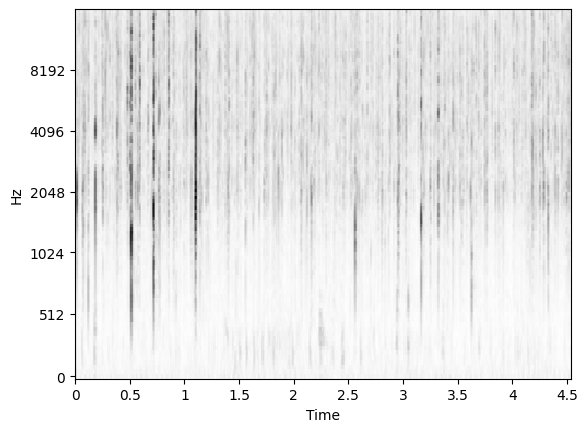

In [19]:
#@title { vertical-output: true }
# Path to cioc target sound folders
cioc_sounds = drive_sample_data_folder + '/Holo'
cioc_sounds_folders = os.listdir(cioc_sounds)

# For each target sound folder, find the first audio file as an example
example_target_sounds = []
for folder in cioc_sounds_folders:
  wav_files = [file for file in os.listdir(os.path.join(cioc_sounds, folder)) if file.lower().endswith('.wav')]
  example_sound_path = os.path.join(cioc_sounds, folder + '/' + wav_files[0])
  example_target_sounds.append(example_sound_path)

# Now view each example target sound
print('Number of different target sounds: ', len(example_target_sounds))
for audio_path in example_target_sounds:
  print('Target sound label: ', audio_path.split('/')[-2])
  audio = audio_utils.load_audio(audio_path, model_config.sample_rate)
  display.plot_audio_melspec(audio, model_config.sample_rate)

In [20]:
# @title Hit run on this cell and pick a target sound

# Ensure the path exists and list directories
if os.path.exists(cioc_sounds):
    sound_folders = [f for f in os.listdir(cioc_sounds) if os.path.isdir(os.path.join(cioc_sounds, f))]
else:
    print("Path does not exist:", cioc_sounds)
    sound_folders = []

# Create and display the dropdown
sound_dropdown = widgets.Dropdown(
    options=sound_folders,
    description='Select sound:',
    disabled=False,
)

# Define a function that reacts to changes in the dropdown
def on_sound_change(change):
    choice = change['new']
    print(f'Changed target sound to: {choice}. Now work through the cells below for this dataset.')

# Attach the observer to the dropdown
sound_dropdown.observe(on_sound_change, names='value')

ipy_display(sound_dropdown)

Dropdown(description='Select sound:', options=('Burp',), value='Burp')

### Prepare the query vector

We're now ready to create the 'query', which uses our selected target sound.  In general, this query is the audio that you're looking for in your search corpus.

Number of indexed audio files in target sound directory: 1
Viewing example: 1


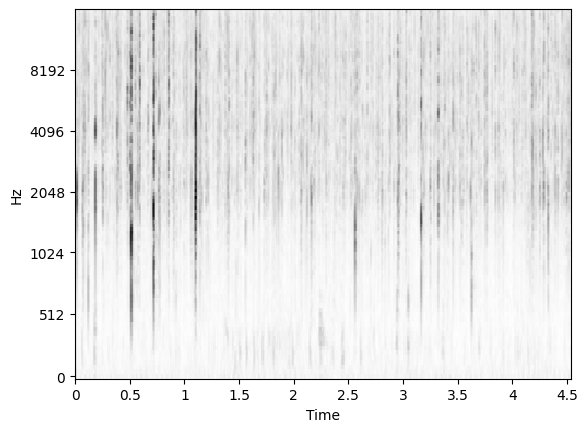

In [23]:
#@title Load and view the query audio sample { vertical-output: true }
target_sound = sound_dropdown.value
target_classes = [target_sound, 'Unknown']

# Select one of the target audio files. Default with 1, but for many sounds
# CIOC users surfaced multiple copies which we can leverage. The print
# out from this cell will tell you if there are others to choose from.
file_index = 1  #@param
file_index = file_index -1

# Build the folder path
target_audio_folder = os.path.join(drive_sample_data_folder, 'Holo', target_sound)

# Retrieve all .wav files
wav_files = [file for file in os.listdir(target_audio_folder) if file.lower().endswith('.wav')]

# Print the total number of audio files
print(f"Number of indexed audio files in target sound directory: {len(wav_files)}")

# Validate the user input and select the audio file
if 0 <= file_index < len(wav_files):
    audio_path = os.path.join(target_audio_folder, wav_files[file_index])
    print(f"Viewing example: {file_index + 1}")
else:
    print("Invalid file index. Please select a valid index up to and including: ", len(wav_files))
    audio_path = None

# Assuming the rest of the code executes only if a valid path is selected
if audio_path:
    audio = audio_utils.load_audio(audio_path, model_config.sample_rate)
    display.plot_audio_melspec(audio, model_config.sample_rate)

#### Select the specific query window

All our target sounds are 5s long, which is the input window length for the SurfPerch model. If using your own data you may have target sound files longer than 5s. You can play with the start_s variable to pick the starting point you wish to use from your longer file.

Note, its usually best to use a minimum sample length of 5s. Silence will be added after the target sound to total 5s otherwise, which doesn't always perform as well when performing the search later on.

Selected audio window:


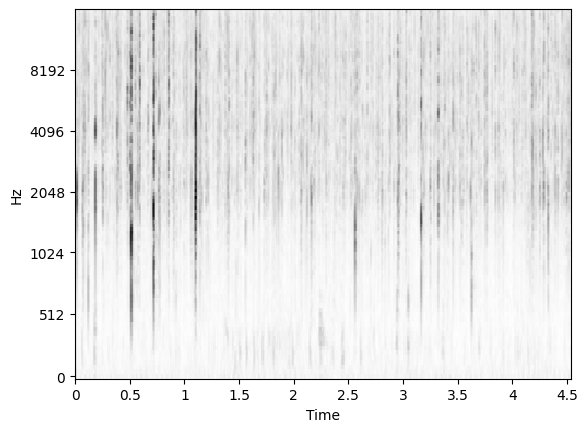

In [24]:
#@title { vertical-output: true }
# If you're audio clip is longer than 5s, adjust start_s to pick your
# prefered start time.
start_s = 0  #@param

# Display the selected window.
print('Selected audio window:')
st = int(start_s * model_config.sample_rate)
end = int(st + model_config.window_size_s * model_config.sample_rate)
if end > audio.shape[0]:
  end = audio.shape[0]
  st = max([0, int(end - model_config.window_size_s * model_config.sample_rate)])
audio_window = audio[st:end]
display.plot_audio_melspec(audio_window, model_config.sample_rate)

query_audio = audio_window
sep_outputs = None

#### Copy CIOC samples to our labeled data directoy
As seen above, CIOC was able to reveal multiple examples for some target sounds. These provide highly useful replicates which can be used to boost the training data for our model later on. Here, we will move them to the `labeled_data_path`, which is the folder where the additional samples we find during the search phase later will be added.

The search phase may well find some of the same samples. The code will make sure not to save duplicate copies.


In [26]:
# The path to an empty directory where the generated labeled samples will be
# placed. Each labeled sample will be placed into a subdirectory corresponding
# to the target class that we select for that sample.
target_audio_outputs = os.path.join(drive_output_directory, target_sound + '/labeled_outputs/' + target_sound)
os.makedirs(target_audio_outputs, exist_ok=True)

# Copy all .wav and .WAV files from target_audio_folder to labeled_data_path
for file in os.listdir(target_audio_folder):
    if file.lower().endswith('.wav'):
        source_path = os.path.join(target_audio_folder, file)
        destination_path = os.path.join(target_audio_outputs, file)
        shutil.copy2(source_path, destination_path)

#### Embed the query

Here we run the query audio through the embedding function to generate the embedding vector for the query.

In [27]:
query = query_audio

embedded_query = embed_fn.embedding_model.embed(query).embeddings[ :, 0, :]

### Create a TensorFlow Dataset (TFDS) wrapper over the embeddings

This is a technical step that wraps our search corpus in a TFDS object to allow us to use some convenient built-in features.

In [28]:
# Use the embedded dataset that we created above...
bootstrap_config = bootstrap.BootstrapConfig.load_from_embedding_path(
    embeddings_path=embedding_output_dir,
    annotated_path=target_audio_outputs
)

project_state = bootstrap.BootstrapState(
    bootstrap_config, embedding_model=embed_fn.embedding_model)

embeddings_ds = project_state.create_embeddings_dataset()

### <a name=top-k-search></a>Run top-k search using a comparison metric

#### Agile modelling step: 1

In this cell we run a "nearest neighbor" search over the search corpus to find embeddings that are closest to the query embedding according to our chosen metric.  These will correspond to snippets of our chosen dataset that sound similar to our query.

The `target_score` variable is a parameter that allows us to surface not just the closest matches, but rather matches that lie some fixed distance away.  When `target_score` is set to `None` (or `0`), the search will return the closest matches.

Recall that our goal in this section is to generate training data for a linear classifier. In order to train a robust model, we want this training dataset to contain both obvious/easy examples as well as not-so-obvious examples. If in our search we just looked for the closest possible matches, we would likely only find easy examples. The `target_score` param allows us to look for examples that might be less obvious (because they are farther away in embedding space).

Additionally, do not underestimate the usefulness of labeling 'Unknown' negative samples. Labeling a broad representation of negative samples present in the full dataset, especially those that currently score as close matches in the search, is key for training a classifier robust to false positives.

**Important note:** You will likely need to come back to this cell and produce more top-k instances by modulating the value of `target_score`. We explain the approach to choosing useful values for `target_score` in the section [Choose a target score](#choosing-target-score).

In [29]:
# Number of search results to capture. top_k = 25 is often a good start,
# but we use 10 for brevity in this demo.
top_k = 73 # @param {type:"number"}

# The Perch codebase supports:
#  'euclidean', which is the standard euclidean distance
#  'cosine', which is the cosine similarity,
#  'mip', which is Maximum Inner Product
metric = 'euclidean'  #@param['euclidean', 'mip', 'cosine']

# Target distance for search results. This lets us try to hone in on a
# 'classifier boundary' instead of just looking at the closest matches.
# Set to 'None' for raw 'best results' search.
target_score = None #@param

results, all_scores = search.search_embeddings_parallel(
    embeddings_ds, embedded_query,
    hop_size_s=model_config.hop_size_s,
    top_k=top_k, target_score=target_score, score_fn=metric,
    random_sample=False)

73it [00:00, 530.70it/s]
2024-11-04 18:26:06.666730: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### User-in-the-loop data labeling (**requires user interaction**)

The cell below displays the search results in a user-interface in the following format:
* Image: a plot visualization of the audio search result (Mel spectrogram, frequency in Hz over time)
* A playback of the audio sample itself
* Metrics and metadata: `rank` position, `source file` of the recording segment, `offset_s` (in seconds) from the recording, and the search `score` (i.e. similarity with the query)
* Candidate labels for the sample

**Instructions to the user:** <br>
For each search result presented below, select either the target label or Unknown class. Samples which present difficult cases can be highly valuable to label, but if any cannot be labeled with confidence then its possible to leave them blank.

**Quick guide on how to verify vocalisations:**

One of the hardest parts of the entire process can be learning to correctly identify the target sounds for yourself. Often this requires a skilled bioacoustician to do well. Many common reef sounds can blur from one clear signal into another, especially tricky pulse, purr and pop vocalizations. When in doubt, take the time to check back against your original target sound. Make use of listening with a good set of earphones or headphones and also visually assessing the spectrogram.

For an easy start try the whoop of the Ambon Damselfish in the Australian dataset!

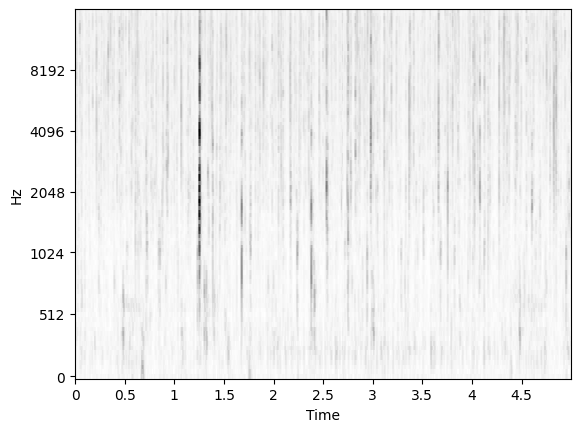

rank        : 0
source file : Ch1_Guam_Unf Day 2/left_20230620T192714_9040035972195475_2.0dB_4.6V_ver3.20.wav
offset_s    : 40.00
score       : 2.18


Button(description='Burp', style=ButtonStyle())

Button(description='Unknown', style=ButtonStyle())

--------------------------------------------------------------------------------


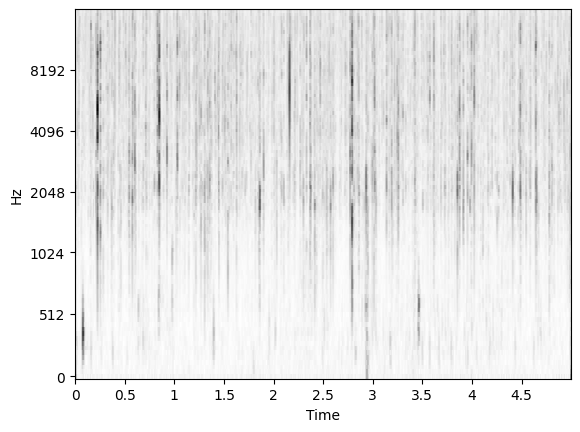

rank        : 1
source file : Ch1_Guam_Unf Day 2/left_20230620T214715_9040035972195475_2.0dB_4.6V_ver3.20.wav
offset_s    : 55.00
score       : 2.18


Button(description='Burp', style=ButtonStyle())

Button(description='Unknown', style=ButtonStyle())

--------------------------------------------------------------------------------


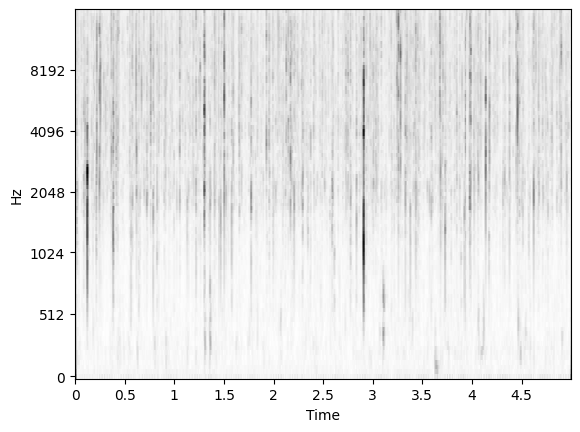

In [ ]:
#@title Display the search results for user labeling. { vertical-output: true }
display.display_search_results(
    project_state=project_state,
    results=results,
    embedding_sample_rate=model_config.sample_rate,
    checkbox_labels=target_classes,
    max_workers=5)

# Let this cell finish executing before labeling the samples

### Choose a target score by plotting a histogram of all distances in the search corpus

During the top-k search step above, the Perch code also computed and saved the distances to *every* point in the search corpus. The actual numerical values of these distances are hard to interpret, but the relative values are very useful. In the following cell we plot a histogram of this set of distances to help us conceptualize the geometry of our embedded dataset. This histogram helps us find and tune our values for the `target_score` variable in the top-k search.

A typical histogram will appear to fit some vaguely-normal looking distribution, possibly skewed left with a heavy tail. While there is no prescriptive formula for finding useful values of `target_score`, the Perch team has found that good choices tend to lie near the left-hand 'hockey-stick' point of the distribution. For example, in the following histogram, you might try playing with values somewhere in the range of 2.8 to 3.1:

<img src="https://drive.google.com/uc?id=1bLc2XDTqutihg4wJSkCfB2DiT4Dpr4UO" width="40%" height="40%">

These tend to correspond to examples that are faint, or have background noise, or are otherwise not especially obvious. Annotating these examples and adding them to the training set is very important because they help the linear model discriminate better on these less-clear "boundary" points. Though take care to make sure your annotations are correct, if in doubt you can leave samples unlabeled.



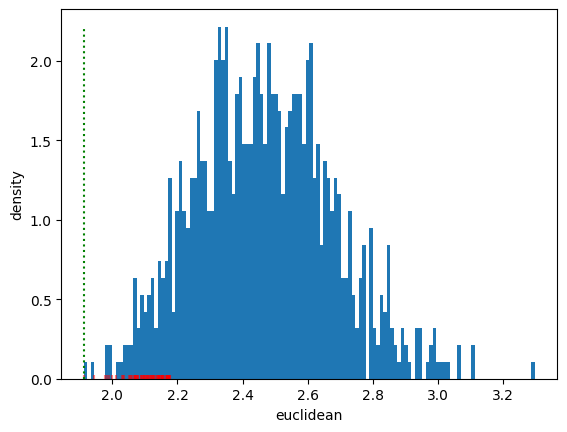

In [31]:
#@title { vertical-output: true }
# Plot histogram of distances.
ys, _, _ = plt.hist(all_scores, bins=128, density=True)
hit_scores = [r.score for r in results.search_results]
plt.scatter(hit_scores, np.zeros_like(hit_scores), marker='|',
            color='r', alpha=0.5)

plt.xlabel(metric)
plt.ylabel('density')
if target_score is not None:
  plt.plot([target_score, target_score], [0.0, np.max(ys)], 'r:')
  # Compute the proportion of scores < target_score.
  hit_percentage = (all_scores < target_score).mean()
  print(f'score < target_score percentage : {hit_percentage:5.3f}')
min_score = np.min(all_scores)
plt.plot([min_score, min_score], [0.0, np.max(ys)], 'g:')

plt.show()

### Write the user-annotated search results to file

This cell saves the annotations you generated in the previous step to your Google Drives.  It writes data to the `labeled_data_path` location that was specified above.

In [33]:
def write_labeled_data(search_results, labeled_data_path: str, sample_rate: int):
  """Write labeled results to the labeled data collection."""
  labeled_data_path = epath.Path(labeled_data_path)
  counts = collections.defaultdict(int)
  duplicates = collections.defaultdict(int)
  for r in search_results:
    labels = [ch.description for ch in r.label_widgets if ch.value]
    if not labels:
      continue
    extension = epath.Path(r.filename).suffix
    filename = epath.Path(r.filename).name[: -len(extension)]
    output_filename = f'{filename}___{r.timestamp_offset}{extension}'
    for label in labels:
      output_path = labeled_data_path / label
      output_path.mkdir(parents=True, exist_ok=True)
      output_filepath = epath.Path(output_path / output_filename)
      if output_filepath.exists():
        duplicates[f'{label}'] += 1
        continue
      else:
        counts[label] += 1
      with output_filepath.open('wb') as f:
        wavfile.write(f, sample_rate, np.float32(r.audio))
  for label, count in counts.items():
    print(f'Wrote {count} examples for label {label}')
  for label, count in duplicates.items():
    print(f'Not saving {count} duplicates for label {label}')

labeled_data_path = os.path.join(drive_output_directory, target_sound + '/labeled_outputs/')
write_labeled_data(results, labeled_data_path, model_config.sample_rate)

Wrote 2 examples for label Unknown


<a name=active-learning></a>
## Train a Linear Classifier with active learning 🤖🧠

#### Agile modelling step: 2


In the agile modelling step 1 above, we labeled samples from the search dataset as matches (by similarity comparison with the queries) for our target classes. If you're satisfied you labelled enough samples during this step, then from here on you will likely want to focus your efforts using the active agile modelling step 2 cells below.

We will now train a simple linear model using those bootstrapped (labeled) data points from the search dataset.

**Important:** in order to be able to train the linear model, we need several examples from each of the two classes (more is better!). If you encounter an error in this section when training the model, you likely did not generate a sufficient amount of labeled data. Please go back to the [Top-k Search](#top-k-search) section and choose a new value of the `target_score` attribute and label some more data.

In [34]:
# @title Load and embed the search-annotated dataset { vertical-output: true }

# Load the training data that is located in the `labeled_data_path` directory.
# In that directory there will be folders corresponding to our target labels

merged = data_lib.MergedDataset.from_folder_of_folders(
    base_dir=labeled_data_path,
    embedding_model=project_state.embedding_model,
    time_pooling='mean',
    load_audio=False,
    target_sample_rate=-2,
    audio_file_pattern='*',
    embedding_config_hash=bootstrap_config.embedding_config_hash(),
)

# Label distribution
lbl_counts = np.sum(merged.data['label_hot'], axis=0)
print('num classes :', (lbl_counts > 0).sum())
print('mean ex / class :', lbl_counts.sum() / (lbl_counts > 0).sum())
print('min ex / class :', (lbl_counts + (lbl_counts == 0) * 1e6).min())

Embedding from Folder of Folders...
Checking for existing embeddings from Folder of Folders...
Found 0 existing embeddings.
Checking for new sources to embed from Folder of Folders...


1it [00:00, 30.18it/s]
2it [00:00, 54.65it/s]


...embedded dataset in  0.08s...
    found 2 classes.
    class Burp / 0 : 1
    class Unknown / 1 : 2
num classes : 2
mean ex / class : 1.5
min ex / class : 1.0


### Train a simple linear model using the labeled embeddings

We use the following hyperparameters which should serve as reasonably performing defaults to train this linear model (classifier):

- `batch_size`: 12
- `num_epochs`: 128
- `num_hiddens`: -1 (to match the dimensions of the embeddings)
- `learning_rate`: 0.001

Additionally, we compute the following metrics to measure the "goodness" of the trained model:
- `acc`: overall accuracy
- `auc_roc`: AUC ROC, or area under the receiving curve
- `cmAP`: mean average precision averaged across species
- `maps`: mean average precision for each class

In [40]:
# Number of random training examples to choose from each class.

# Note that if you don't have very many samples you'll need to set
# train_ratio=None and train_examples_per_class to a value that is
# less than the minimum number of examples you have of each class.

# Set exactly one of train_ratio and train_examples_per_class
train_ratio = 1  #@param
train_examples_per_class = None  #@param

# Number of random re-trainings. In other words, this value indicates how many
# models we will train, each will use a new randomly selected combination of
# our labeled samples for training and testing. By training multiple models,
# we get a sense of model robustness. Here, we train 3, but feel free to
# increase it for added confidence in the model's performance.
num_seeds = 3  #@param

# Classifier training hyperparams.
# These should be good defaults.
batch_size = 12
num_epochs = 128
num_hiddens = -1
learning_rate = 1e-3

In [41]:
# This cell trains the linear model(s) and outputs some summary statistics for
# each model. If you only have num_seeds = 1 then we'll only train a single
# model here.
metrics = collections.defaultdict(list)
for seed in tqdm.tqdm(range(num_seeds)):
  if num_hiddens > 0:
    model = classify.get_two_layer_model(
        num_hiddens, merged.embedding_dim, merged.num_classes)
  else:
    model = classify.get_linear_model(
        merged.embedding_dim, merged.num_classes)
  # Explicitly cast train_ratio to int to ensure integer indices for splitting
  # This assumes train_ratio represents the number of training samples per class.
  # If it's supposed to be a proportion, more changes are required within the library
  # to ensure integer indices are generated.

  run_metrics = classify.train_embedding_model(
      model, merged, int(train_ratio), train_examples_per_class,
      num_epochs, seed, batch_size, learning_rate)
  metrics['acc'].append(run_metrics.top1_accuracy)
  metrics['auc_roc'].append(run_metrics.auc_roc)
  metrics['cmap'].append(run_metrics.cmap_value)
  metrics['maps'].append(run_metrics.class_maps)
  metrics['test_logits'].append(run_metrics.test_logits)

  0%|          | 0/3 [00:05<?, ?it/s]


IndexError: arrays used as indices must be of integer (or boolean) type

#### Compute the average metrics and print the model performance

In the previous cells, the `num_seeds` param controls how many times we train a model.  Each time we train a model there is some randomness in terms of which data points we choose from our labeled data, as well as some randomness in the model's initialization.  We can get a sense of how robust our classifier is by training multple times and looking at the summary statistics computed by the following cell.  A low `auc_roc` value (ie, less than 0.9 or so) probably indicates that we should generate some more training data.

**Note**: If you are new to labeling marine sounds, it can also be tricky to be sure you've labeled everything correctly.

In [ ]:
mean_acc = np.mean(metrics['acc'])
mean_auc = np.mean(metrics['auc_roc'])
mean_cmap = np.mean(metrics['cmap'])
# Merge the test_logits into a single array.
test_logits = {
    k: np.concatenate([logits[k] for logits in metrics['test_logits']])
    for k in metrics['test_logits'][0].keys()
}

print(f'acc:{mean_acc:5.2f}, auc_roc:{mean_auc:5.2f}, cmap:{mean_cmap}')
for lbl, auc in zip(merged.labels, run_metrics.class_maps):
  if np.isnan(auc):
    continue
  print(f'\n{lbl:8s}, auc_roc:{auc:5.2f}')
  colab_utils.prstats(f'test_logits({lbl})',
                      test_logits[merged.labels.index(lbl)])

If you have completed the active learning loop below a few times, and have a high auc_roc score (>0.95 or close to it), then move on to the 'Inference stage' cell below.

### The Active Learning Loop: Generating more training examples


### Generate new samples using logit scores


In [ ]:
# Choose the target class to work with.  This must be one of the values from
# the target_classes list above (target_sound or 'Unknown')

target_class = target_sound  #@param

# Choose a target logit. You can start by setting this to 'None' to get the
# highest-logit examples, which should reveal more of the target sound.
# Next, selecting 0.0 or the hockey stick bend should reveal samples the model
# currently finds difficult - these are very valuable to label.
target_logit = None  #@param

# Number of results to display.
num_results = 10  #@param

# Create the embeddings dataset.
target_class_idx = merged.labels.index(target_class)
results, all_logits = search.classifer_search_embeddings_parallel(
    embeddings_classifier=model,
    target_index=target_class_idx,
    embeddings_dataset=embeddings_ds,
    hop_size_s=model_config.hop_size_s,
    target_score=target_logit,
    top_k=num_results
)

In [ ]:
#@title { vertical-output: true }
# Plot the histogram of model logits.
_, ys, _ = plt.hist(all_logits, bins=128, density=True)
plt.xlabel(f'{target_class} logit')
plt.ylabel('density')
plt.plot([target_logit, target_logit], [0.0, np.max(ys)], 'r:')
plt.show()

In [ ]:
#@title Display results for the target label { vertical-output: true }

display_labels = merged.labels

extra_labels = []  #@param
for label in extra_labels:
  if label not in merged.labels:
    display_labels += (label,)
if 'Unknown' not in merged.labels:
  display_labels += ('Unknown',)

display.display_search_results(
    results=results,
    project_state=project_state,
    embedding_sample_rate=model_config.sample_rate,
    checkbox_labels=target_classes,
    max_workers=5)

#### Add selected results to the labeled data

As before, once we've annotated the examples from the previous cell, we'll save them in the `labeled_data_dir`.

In [ ]:
results.write_labeled_data(labeled_data_path, model_config.sample_rate)

Now return to the 'Agile modelling step: 2' cell and work down from here cell by cell once again, until you are satisified with the auc_roc score output by the 'Compute the average metrics' cell.

If you are satsified by the score, move on to the final stage below...

### Inference stage: write the trained model's classification results

Usually the purpose of creating a model in the first place is to bulk-process many hours of raw audio.  In this cell, we'll run our linear model over the entire search corpus.  The output will be a CSV containing the results.  

The `threshold` parameter is the minimum logit score that will get recorded (ie, samples wfor which the model had a low confidence are  omitted from the results to ensure high confidence in the final results).  You can tune this score to generate different output CSVs at different confidence scores. Alternatively, if you notice in your results csv that many periods are omitted but you don't want to introduce potential error by lowering the logit threshold, you can increase the strength of logit scores by carefully labeling more data and retraining your classifier using the active learning process.

In [ ]:
# { vertical-output: true }

threshold = 1.0  #@param
output_filepath = os.path.join(drive_output_directory, dataset_folder, target_sound + '/inference_'+ target_sound + '.csv')

def classify_batch(batch):
  """Classify a batch of embeddings."""
  emb = batch[tf_examples.EMBEDDING]
  emb_shape = tf.shape(emb)
  flat_emb = tf.reshape(emb, [-1, emb_shape[-1]])
  logits = model(flat_emb)
  logits = tf.reshape(
      logits, [emb_shape[0], emb_shape[1], tf.shape(logits)[-1]])
  # Take the maximum logit over channels.
  logits = tf.reduce_max(logits, axis=-2)
  batch['logits'] = logits
  return batch


inference_ds = embeddings_ds.map(
    classify_batch, num_parallel_calls=tf.data.AUTOTUNE
)
all_embeddings = []
all_logits = []

with open(output_filepath, 'w') as f:
  # Write column headers.
  headers = ['filename', 'timestamp_s', 'label', 'logit']
  f.write(', '.join(headers) + '\n')
  for ex in tqdm.tqdm(inference_ds.as_numpy_iterator()):
    all_embeddings.append(ex['embedding'])
    all_logits.append(ex['logits'])
    for t in range(ex['logits'].shape[0]):
      for i, label in enumerate(merged.labels):
        if ex['logits'][t, i] > threshold:
          offset = ex['timestamp_s'] + t * model_config.hop_size_s

          logit = '{:.2f}'.format(ex['logits'][t, i])
          row = [ex['filename'].decode('utf-8'),
                 '{:.2f}'.format(offset),
                 label, logit]
          f.write(', '.join(row) + '\n')

all_embeddings = np.concatenate(all_embeddings, axis=0)
all_logits = np.concatenate(all_logits, axis=0)
print('Saved results to: ', output_filepath)

<a name=results></a>
# Results 📊

With the example datasets used in this demo, we can also compare the occurence of target sounds between the relevant habitat types the data was gathered from.

The csv results file contains a list of all filenames and their predicted label. Below is some custom code for the datasets used in this demo which reads the filenames present in the csv and produces plots.




## Load inference results

In [ ]:
# Find the output folders for each target sound analysed so far
sound_folders = os.listdir(os.path.join(drive_output_directory, dataset_folder))
if 'raw_embeddings' in sound_folders:
    sound_folders.remove('raw_embeddings')

# Store results in dict
all_results_dict = {}
for sound in sound_folders:
  # Load results csv
  results_csv_path = os.path.join(drive_output_directory,
                                  dataset_folder,
                                  sound + '/inference_'+ sound + '.csv')
  results_df = pd.read_csv(results_csv_path)

  # Strip white space
  results_df.columns = results_df.columns.str.strip()
  results_df = results_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

  # Find the files with the target sound and store their habitat type
  target_detected = results_df[results_df['label'] == sound]
  source_files = list(target_detected['filename'])
  habitat_type = [item[20] for item in source_files] # our data has the habitat type denoted at the 20th character in the filename
  habitat_counts = Counter(habitat_type)
  habitat_counts_dict = dict(habitat_counts)
  all_results_dict[sound] = habitat_counts_dict

## Plot results

In [ ]:
# Define the number of subplots based on the number of sounds
num_sounds = len(all_results_dict)
fig, axes = plt.subplots(1, num_sounds, figsize=(num_sounds * 5, 5))

# Check if there's only one sound to ensure 'axes' is iterable
if num_sounds == 1:
    axes = [axes]

# Extract and sort all unique habitat types from all sound types
unique_habitats = sorted(set(habitat for counts in all_results_dict.values() for habitat in counts))

# Generate a color map for each habitat type
color_map = plt.cm.get_cmap('viridis_r', len(unique_habitats))
colors = {habitat: color_map(i) for i, habitat in enumerate(unique_habitats)}

# Define the width of each bar
bar_width = 0.35

# Iterate over each sound and its respective axis
for ax, (sound, counts) in zip(axes, all_results_dict.items()):
    # Create bars for each habitat type within this sound type
    for j, habitat in enumerate(unique_habitats):
        # Set position and height for this bar then add it
        position = j * bar_width
        height = counts.get(habitat, 0)
        ax.bar(position, height, bar_width, color=colors[habitat])

    # Set labels, title, and y-ticks for this subplot
    ax.set_title(sound)
    ax.set_xticks([j * bar_width for j in range(len(unique_habitats))])
    ax.set_xticklabels(unique_habitats)
    ax.set_xlabel('Habitat type')
    ax.set_ylabel('Count')

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()

## Preliminary findings
Using a full run through of each dataset and the target sounds, we oberved some preliminary findings.

**Indonesia**

We observe a difference in the rate of occurence for our first two target sounds between healthy (H) and degraded (D) reefs. We can also see what looks like evidence for recovery of these vocalisations within the soundscape of restored (R) sites. Interestingly, for Parrotfish grazing, we observe the highest rate on restored reefs. Parrotfish grazing is an important ecological function, which could have implications for restoration.
<img src="https://raw.githubusercontent.com/BenUCL/surfperch/surfperch/manuscript-additions/colab_pics/indo_results_fig.png" width="100%">

**Great Barrier Reef**

As expected we observe a higher rate of two vocalisations in  recordings from the higher fish diversity sites (H) than those where this was low (L). However, the charismatic whooping from the [Ambon Damselfish](https://fishbase.mnhn.fr/summary/5715) appears more abundant on the lower diversity reef sites which could be indicative of the habitat its selecting.
<img src="https://raw.githubusercontent.com/BenUCL/surfperch/surfperch/manuscript-additions/colab_pics/aus_results_fig.png" width="100%">


**Philippines**

CIOC revealed two frequently occuring sounds from the  dataset: short purrs, often known as 'pulse trains' that typically originate from damselfish, and, pops. The classifier found both occured more often in recordings from the reefs in a marine protected area (P) than those in unprotected (U) areas.

<img src="https://raw.githubusercontent.com/BenUCL/surfperch/surfperch/manuscript-additions/colab_pics/phil_results_fig.png" width="66%">


**Conclusions**

Importantly, these results are only preliminary. We only used 15-25 hrs from each dataset for the purposes of this demo. These preliminary results can be reproduced if you replace the 'SurfPerch Demo with Calling in Our Corals Outputs' folder in your Google Drive with the same folder from our full run through of this notebook. This folder is stored in the tutorial.zip of the research articles [supplementary repository](https://doi.org/10.5281/zenodo.11060189).

Scientists are now working with the full Calling in Our Corals outputs and the Perch framework to study this data in depth. We would love your help! By annotating more data on the [CIOC platform](https://artsandculture.google.com/experiment/calling-in-our-corals/zgFx1tMqeIZyTw?hl=en) this will contribute to monitoring reef restoration globally.

We hope this gives you an idea of how the Perch framework can be useful for real world bioacoustic challenges! We encourage users to adapt this to their own data, and use the results files to conduct data analysis on their own problem sets.